## Build a model from python

In [1]:
import hydromt
from hydromt_sfincs import SfincsModel, utils
import geopandas as gpd
import pandas as pd
import xarray as xr

This example shows you how to setup a model schematization from existing preprocessed GIS raster data and manually add forcing data. Note that all rasters should be on exactly the same grid and must have proper metadata including the CRS which must be a projected system with unit in meters, such as a UTM zone!

To understand how the data is stored in the SfincsModel object we have a look at some internal variables:

- MAPS: saved as `hydromt.RasterDataset`; use `.set_staticmaps()` to add new maps
- GEOMS: saved as `dict` of `geopandas.GeoDataFrame`; use `.set_staticgeoms()` to add new geometries
- FORCING: saved as `dict` of `xarray.DataArray` or `hydromt.GeoDataArray` in case the forcing is for specific xy locations; use `.set_forcing()` in general, or the convenience `.set_forcing_1d` for 1D forcing.

The following MAPS, GEOMS and FORCINGS are currently recognized:

In [2]:
SfincsModel._MAPS.values()

dict_values(['dep', 'msk', 'scs', 'manning', 'qinf'])

In [3]:
SfincsModel._GEOMS.values()

dict_values(['obs', 'weir', 'thd'])

In [4]:
SfincsModel._FORCING.values()

dict_values([('bzs', 'bnd'), ('dis', 'src'), ('precip', None), ('netampr', None)])

### read raster data

Here we first make a directory with an elevation and mask raster files from which we can build the model.
For the sake of this example we export these layers from an existing model. 
In practice you could setup these layers in a GIS such as QGIS based on your own data.

In [5]:
# export a model to gis files using hydromt (only for sake of the example)
mod0 = SfincsModel(root="sfincs_riverine", mode="r")
mod0.read()
mod0.write_raster(variables=["staticmaps.dep"], root="gis_data")

In [6]:
# check content of our folder
!ls gis_data

dep.tif


In [7]:
# check meta data on our geotiff file (specifically note the crs attribute!)
!rio info gis_data/dep.tif

{"bounds": [264450.0, 5073200.0, 289150.0, 5091850.0], "colorinterp": ["gray"], "compress": "deflate", "count": 1, "crs": "EPSG:32633", "descriptions": [null], "driver": "GTiff", "dtype": "float32", "height": 373, "indexes": [1], "interleave": "band", "lnglat": [12.124685403666371, 45.86010307727549], "mask_flags": [["nodata"]], "nodata": -9999.0, "res": [50.0, 50.0], "shape": [373, 494], "tiled": false, "transform": [50.0, 0.0, 264450.0, 0.0, -50.0, 5091850.0, 0.0, 0.0, 1.0], "units": [null], "width": 494}


Here we read a single raster (dep.tif) using the hydromt.open_raster method. If all data in the a folder is on an identical grid we can read it into a single xarray.Dataset with the hydromt.open_mfraster method.

In [8]:
# read all data to a Dataset
# note that the names are taken from the file basenames
da_dep = hydromt.open_raster("gis_data/dep.tif")
da_dep

<xarray.DataArray (y: 373, x: 494)>
dask.array<getitem, shape=(373, 494), dtype=float32, chunksize=(373, 494), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.092e+06 5.092e+06 ... 5.073e+06 5.073e+06
  * x            (x) float64 2.645e+05 2.645e+05 ... 2.891e+05 2.891e+05
    spatial_ref  int64 1
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0

### setup SFINCS model

First we initiate an new model instance in a new model root folder in writing mode:

In [9]:
mod = SfincsModel(root="sfincs_from_py", mode="w")
# Note this is still an empty model with no maps
len(mod.staticmaps) == 0

True

We can add staticmaps to the model using the `set_staticmaps()` method. Here it is important that the model layers are on a identical grid, otherwise these will not be excepted. 

Note that geotiff raster typically has a N->S orientation while the SFINCS model uses a S->N orientation. If the staticmaps are  kept in N->S orientation the y-axis will be flipped by the `set_staticmaps()` method. Compare the y dimension between ds and .staticmaps to check.

In [10]:
mod.set_staticmaps(da_dep, name="dep")
mod.staticmaps

<xarray.Dataset>
Dimensions:      (y: 373, x: 494)
Coordinates:
  * y            (y) float64 5.092e+06 5.092e+06 ... 5.073e+06 5.073e+06
  * x            (x) float64 2.645e+05 2.645e+05 ... 2.891e+05 2.891e+05
    spatial_ref  int64 1
Data variables:
    dep          (y, x) float32 dask.array<chunksize=(373, 494), meta=np.ndarray>

Next we load a default config which we need to modify for our example

In [11]:
mod.read_config()  ## laods default config if no sfincs.inp is found in model root
mod.update_spatial_attrs()  # sets mmax, nmax, dx, dy, x0, y0 & epsg based on staticmaps
mod.config  # inspect config

{'mmax': 494,
 'nmax': 373,
 'dx': 50.0,
 'dy': 50.0,
 'x0': 264450.0,
 'y0': 5073200.0,
 'rotation': 0,
 'epsg': 32633,
 'inputformat': 'bin',
 'outputformat': 'net',
 'tref': '20000101 000000',
 'tstart': '20000101 000000',
 'tstop': '20000102 000000',
 'dtout': 3600,
 'dthisout': 600,
 'dtmaxout': 86400,
 'advection': 0,
 'alpha': 0.75,
 'huthresh': 0.05,
 'theta': 0.9,
 'min_lev_hmax': -1,
 'zsini': 0,
 'qinf': 0,
 'manning_land': 0.04,
 'manning_sea': 0.02,
 'rgh_lev_land': 0,
 'depfile': 'sfincs.dep',
 'mskfile': 'sfincs.msk',
 'indexfile': 'sfincs.ind'}

Next we need to define the mask and boundaries where water can leave the model domain. For a riverine application this can be done using the ``setup_river_outflow()`` method to find set cells boundary cells within a range from river outflow points to an open boundary. The more general ``setup_bounds()`` method can be used to setup both open and water level boundary cells.

In [12]:
# setup mask with open boundaries at the downstream end of
mod.setup_mask()  # sets mask based on valid dep cells
mod.setup_river_hydrography()  # create hydrography data from dep file
mod.setup_river_outflow()  # use default settings

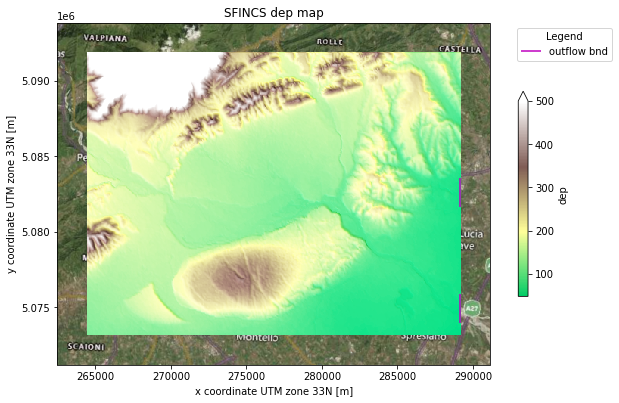

In [13]:
# let's visualize the model schematization
_ = mod.plot_basemap(fn_out=None, vmax=500)

### Add discharge forcing

The SFINCS discharge forcing is set based on a combination of a the src (xy point locations) and dis (timeseries) files. In hydroMT the src locations are represented by a geopandas.GeoDataFrame in the staticgeoms attribute and dis timeseries by a xarray.DataArray with 'time' and 'index' dimensions in the forcing attribute. SFINCS waterlevel forcing can be set similarly using 'bzd' (xy point locations) and 'bzs' (timeseries) and precipitation with 'precip' (timeseries). 

NOTE: If csv or netcdf files with location and timeseries are available, the `setup_q_forcing()` method is recommended. River inflow points can also be found based on a flow direction dataset using `setup_river_inflow()`

In [14]:
# here we create three source points with a simple triangular discharge hydrograph
# setup locations
x = [264891.02, 264903.71, 277443.57]
y = [5083000.61, 5085039.90, 5091621.70]
pnts = gpd.points_from_xy(x, y)
index = [1, 2, 3]  # NOTE that the index should start at one
src = gpd.GeoDataFrame(index=index, geometry=pnts, crs=mod.crs)
src

,geometry
1,POINT (264891.020 5083000.610)
2,POINT (264903.710 5085039.900)
3,POINT (277443.570 5091621.700)


In [15]:
# setup discharge timeseries
mod.set_config("tref", "20210101 000000")
mod.set_config("tstart", "20210101 000000")
mod.set_config("tstop", "20210102 000000")
time = pd.date_range(
    start=utils.parse_datetime(mod.config["tstart"]),
    end=utils.parse_datetime(mod.config["tstop"]),
    periods=3,
)
ts = pd.DataFrame(
    index=time, columns=index, data=[[100, 50, 80], [500, 250, 300], [100, 50, 80]]
)
ts

,1,2,3
2021-01-01 00:00:00,100,50,80
2021-01-01 12:00:00,500,250,300
2021-01-02 00:00:00,100,50,80


In [16]:
# update forcing in model
mod.set_forcing_1d(name="discharge", ts=ts, xy=src)

In [17]:
# Note that the data has been converted to a GeoDataset which combines the timeseries and spatial data.
mod.forcing["dis"]

<xarray.DataArray 'dis' (index: 3, time: 3)>
array([[100, 500, 100],
       [ 50, 250,  50],
       [ 80, 300,  80]])
Coordinates:
  * index        (index) int64 1 2 3
  * time         (time) datetime64[ns] 2021-01-01 2021-01-01T12:00:00 2021-01-02
    x            (index) float64 2.649e+05 2.649e+05 2.774e+05
    y            (index) float64 5.083e+06 5.085e+06 5.092e+06
    spatial_ref  int64 1
Attributes:
    standard_name:  discharge
    unit:           m3.s-1

In [18]:
# to retrieve the src point locations use the `.vector.to_gdf()` method
mod.forcing["dis"].vector.to_gdf()

,geometry
index,
1,POINT (264891.020 5083000.610)
2,POINT (264903.710 5085039.900)
3,POINT (277443.570 5091621.700)


In [19]:
# The config has also been updated with a disfile and srcfile entry
mod.config

{'mmax': 494,
 'nmax': 373,
 'dx': 50.0,
 'dy': 50.0,
 'x0': 264450.0,
 'y0': 5073200.0,
 'rotation': 0,
 'epsg': 32633,
 'inputformat': 'bin',
 'outputformat': 'net',
 'tref': '20210101 000000',
 'tstart': '20210101 000000',
 'tstop': '20210102 000000',
 'dtout': 3600,
 'dthisout': 600,
 'dtmaxout': 86400,
 'advection': 0,
 'alpha': 0.75,
 'huthresh': 0.05,
 'theta': 0.9,
 'min_lev_hmax': -1,
 'zsini': 0,
 'qinf': 0,
 'manning_land': 0.04,
 'manning_sea': 0.02,
 'rgh_lev_land': 0,
 'depfile': 'sfincs.dep',
 'mskfile': 'sfincs.msk',
 'indexfile': 'sfincs.ind'}

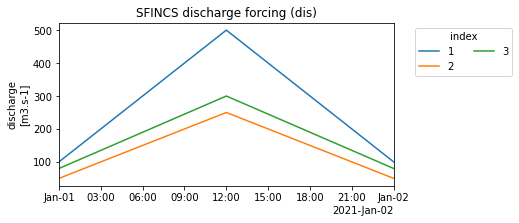

In [20]:
# let's visualize the model forcing timeseries
# TIP: rerun the plot_basemaps above to see the src point locations
_ = mod.plot_forcing(fn_out=None)

### write to file

If we are satisfied with the model schematization and forcing we can write it to disk. 
Here we use the `write` method to write the full model schematization, seperate components can be writen individually with write_<component> methods e.g. `write_staticmaps`, `write_config` etc.

In [21]:
mod.write()  #